# Indian pines HSI classification


## Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import sklearn.linear_model as linmod
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.layers import Flatten, Dense, Dropout, Input, Conv1D
from keras.utils import to_categorical, set_random_seed
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import logging
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import tables as tab
import pandas as pd
import random


c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [3]:
random_seed = 42

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Directory to save results
output_dir = "model_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data preprocessing

### Define helper functions

In [4]:
# load some helper functions
def get_PRISMA_vnir(path):
    file1 = tab.open_file(path)
    d2 = file1.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")
    vnir = d2['Data Fields']['VNIR_Cube'][:,3:-3,:]
    file1.close()
    vnir = vnir.transpose((0, 2, 1))
    return vnir

def rgbplot(vnir):
    rgb_flat = vnir[:,[35,45,52]]
    rgb = rgb_flat.reshape((1000, 1000, 3))/ 10000#.
    rgb[rgb>1] = 1
    plt.imshow(rgb)
    #return rgb
    
def intobatches(orderlist, size):
    batches = []
    j = 0
    while j < len(orderlist):
        i = 0
        batch = []
        while i < size:
            try:
                batch.append(orderlist[j+i])
            except IndexError:
                batches.append(batch)
                return batches
            i += 1
        j += i
        batches.append(batch)
    return batches

### Load dataset

In [8]:
# load list of images
path_to_xls = "./Faubai/2023_02_22_Faubai_dataset_v1.xlsx"
datalist = pd.read_excel(path_to_xls)

# remove datetimes that are not a number
truetime = datalist['datetime'] > pd.Timestamp(2010)
datalist = datalist[truetime]
train_data = datalist[datalist['Train'] == 'X']
test_data = datalist[datalist['Test'] == 'X']

print(datalist)

# find the relevant files
path = "./Faubai/"

fname_dict = {}
for i in range(len(datalist)):
    for root,d_names,f_names in os.walk(path):
        for f in f_names:
            if f == datalist['name'][i] + ".he5":
                fname_dict[datalist['name'][i]] = (os.path.join(root, f))
                
# find the labels also               
lname_dict = {}
for i in range(len(datalist)):
    for root,d_names,f_names in os.walk(path):
        for f in f_names:
            if (datalist['name'][i] in f) and ("labels.csv" in f):
                lname_dict[datalist['name'][i]] = (os.path.join(root, f))


# determine images to include in training
training_files = [[fname_dict[i], lname_dict[i]] for i in train_data['name']]

print(training_files)


# determine images to include in test
test_files = [[fname_dict[i], lname_dict[i]] for i in test_data['name']]

print(test_files)


               datetime        lat        lon   regions countries  \
0   2020-04-21 11:02:25  63.175179   9.014432     Tr, M         N   
1   2020-04-21 11:02:29  62.923306   8.816792     Tr, M         N   
2   2020-04-21 11:02:33  62.671070   8.621074         M         N   
3   2020-04-21 11:02:38  62.417690   8.427835      M, I         N   
4   2020-04-21 11:02:42  62.163586   8.236990      M, I         N   
..                  ...        ...        ...       ...       ...   
100 2022-09-07 10:46:30  61.003662  11.152502         I         N   
101 2022-09-07 10:46:34  60.750317  10.975411         I         N   
102 2022-09-07 10:46:38  60.496517  10.799993     I, Vi         N   
103 2022-09-07 10:46:43  60.241695  10.626207  I, O, Vi         N   
104 2022-09-07 10:46:47  59.986309  10.454604     O, Vi         N   

                                                  name      pine    spruce  \
0    PRS_L1_STD_OFFL_20200421110225_20200421110229_...   31127.0   23435.0   
1    PRS_L1_STD

[0.7630078679220946, 0.6366530987394958, 0.3527471491848082, 0.6637250017792328, 0.940801638116777, 0.9926566952011023]


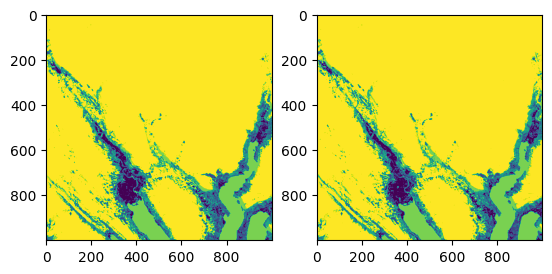

In [7]:
# load first image
# extract VNIR component
vnir = get_PRISMA_vnir(training_files[0][0])
labels = np.loadtxt(training_files[0][1], dtype=np.uint8)
vnir = vnir.reshape((-1, 60))
labels = labels.flatten()

# get a random selection of the pixels
random_selection = np.arange(len(vnir))
np.random.shuffle(random_selection)

# initialize SVM on VNIR
svm2train = linmod.SGDClassifier(max_iter=10000, tol=1e-3, eta0=0.1, learning_rate='adaptive')
svm2train.fit(vnir[random_selection[:10000]], labels[random_selection[:10000]])

# do prediction on the scene
prediction = svm2train.predict(vnir)

# plot the prediction
fig, ax = plt.subplots(1,2)
ax[0].imshow(labels.reshape((1000,1000)))
ax[1].imshow(prediction.reshape((1000,1000)))

#print accuracy
scores = []
for i in np.arange(6):
    m = labels==i
    scores.append((labels[m]==prediction[m]).sum()/m.sum())
print(scores)

## Develope models

### Initialize models

In [11]:
# Define individual models
svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', gamma='scale', random_state=42)
logistic_regression_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
decision_tree_model = DecisionTreeClassifier(random_state=42)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_model = LGBMClassifier(random_state=42)


### Make training and test datasets

In [7]:
train_batch = random.sample(training_files, 5)

X_train = []
y_train = []

for img in train_batch:

    X_train.extend(get_PRISMA_vnir(img[0]).reshape((-1, 60))[:10000])
    y_train.extend(np.loadtxt(img[1], dtype=np.uint8).flatten()[:10000])
    print(img)

print(np.shape(X_train))
print(np.shape(y_train))


['./Faubai/datalake\\PRS_L1_STD_OFFL_20200522095912_20200522095916_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20200522095912_20200522095916_0001_F_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20210802102708_20210802102712_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20210802102708_20210802102712_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20200421110238_20200421110242_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20200421110238_20200421110242_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20200623104952_20200623104957_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20200623104952_20200623104957_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20210913105320_20210913105324_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20210913105320_20210913105324_0001_labels.csv']
(50000, 60)
(50000,)


In [9]:
test_batch = random.sample(test_files, 5)

X_test = []
y_test = []

for img in test_batch:

    X_test.extend(get_PRISMA_vnir(img[0]).reshape((-1, 60))[:10000])
    y_test.extend(np.loadtxt(img[1], dtype=np.uint8).flatten()[:10000])
    print(img)

print(np.shape(X_test))
print(np.shape(y_test))

['./Faubai/datalake\\PRS_L1_STD_OFFL_20210722103959_20210722104004_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20210722103959_20210722104004_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20220825102040_20220825102045_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20220825102040_20220825102045_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20210913105315_20210913105320_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20210913105315_20210913105320_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20220902105915_20220902105919_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20220902105915_20220902105919_0001_labels.csv']
['./Faubai/datalake\\PRS_L1_STD_OFFL_20210403104327_20210403104331_0001.he5', './Faubai/TEST\\PRS_L1_STD_OFFL_20210403104327_20210403104331_0001_labels.csv']
(50000, 60)
(50000,)


In [19]:
import numpy as np
from collections import Counter

# Convert lists to numpy arrays for easier statistical calculations
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Calculate label distribution for y_train and y_test
y_train_distribution = Counter(y_train_np)
y_test_distribution = Counter(y_test_np)

print("\ny_train label distribution (sorted by label number):")
for label, count in sorted(y_train_distribution.items()):
    print(f"Label {label}: {count} instances")

print("\ny_test label distribution (sorted by label number):")
for label, count in sorted(y_test_distribution.items()):
    print(f"Label {label}: {count} instances")


y_train label distribution (sorted by label number):
Label 0: 15706 instances
Label 1: 10505 instances
Label 2: 4513 instances
Label 3: 4742 instances
Label 4: 1676 instances
Label 5: 12858 instances

y_test label distribution (sorted by label number):
Label 0: 12570 instances
Label 1: 9770 instances
Label 2: 5911 instances
Label 3: 14572 instances
Label 4: 6966 instances
Label 5: 211 instances


### Train and evaluate models

In [13]:
# Train, predict and evaluate each model
def train_predict_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    logging.info(f"Training {model_name} model...")
    model.fit(X_train, y_train)
    
    logging.info(f"{model_name} predicting on test dataset...")
    # Predict on test set
    y_pred = model.predict(X_test)
    

    logging.info(f"Evaluating {model_name} and storing results...")
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results = {
        "Accuracy": accuracy,
        "F1-Score": f1
    }

    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")   
    
    # Save results to a file
    result_file = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")
    with open(result_file, 'w') as f:
        json.dump(results, f, indent=4)
    
    # Visualize and save confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"))

In [12]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(svm_model, "SVM", X_train, X_test, y_train, y_test)

2024-11-25 13:51:39,991 - INFO - Training SVM model...


NameError: name 'y' is not defined

<Figure size 1000x700 with 0 Axes>

2024-11-25 13:58:55,173 - INFO - Training Logistic Regression model...
C:\Users\elise\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024-11-25 13:59:06,977 - INFO - Logistic Regression predicting on test dataset...
2024-11-25 13:59:07,003 - INFO - Evaluating Logistic Regression and storing results...


Accuracy: 0.50892
F1-Score: 0.49544833252788334


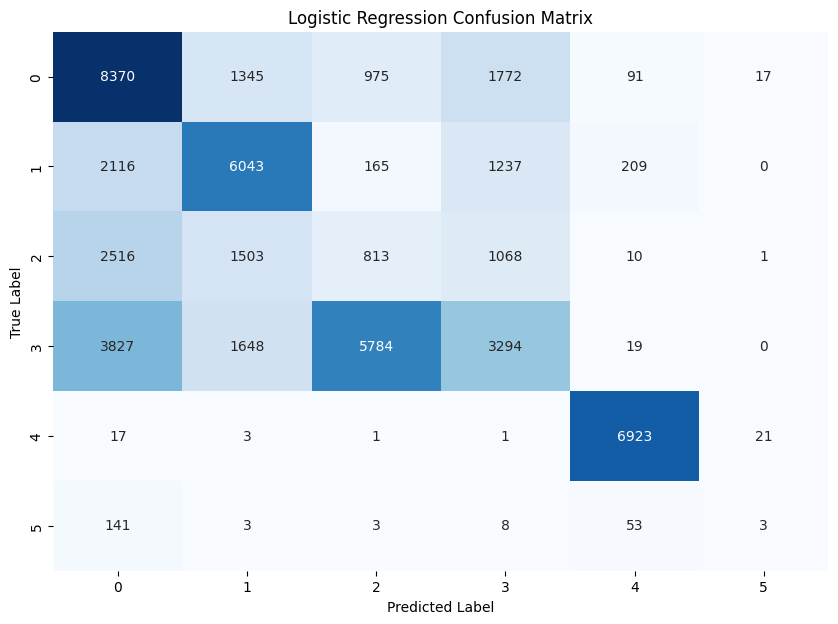

In [14]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(logistic_regression_model, "Logistic Regression", X_train, X_test, y_train, y_test)

2024-11-25 13:59:40,043 - INFO - Training Random Forest model...
2024-11-25 14:00:11,519 - INFO - Random Forest predicting on test dataset...
2024-11-25 14:00:12,073 - INFO - Evaluating Random Forest and storing results...


Accuracy: 0.4702
F1-Score: 0.38595943620589


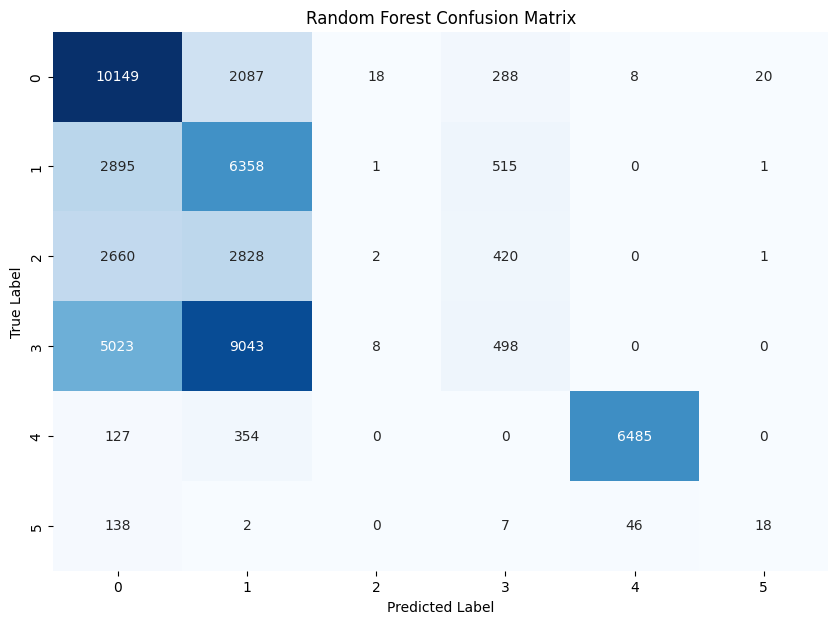

In [15]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(random_forest_model, "Random Forest", X_train, X_test, y_train, y_test)

2024-11-25 14:00:37,273 - INFO - Training KNN model...
2024-11-25 14:00:37,297 - INFO - KNN predicting on test dataset...
2024-11-25 14:01:07,954 - INFO - Evaluating KNN and storing results...


Accuracy: 0.44792
F1-Score: 0.3757042451712596


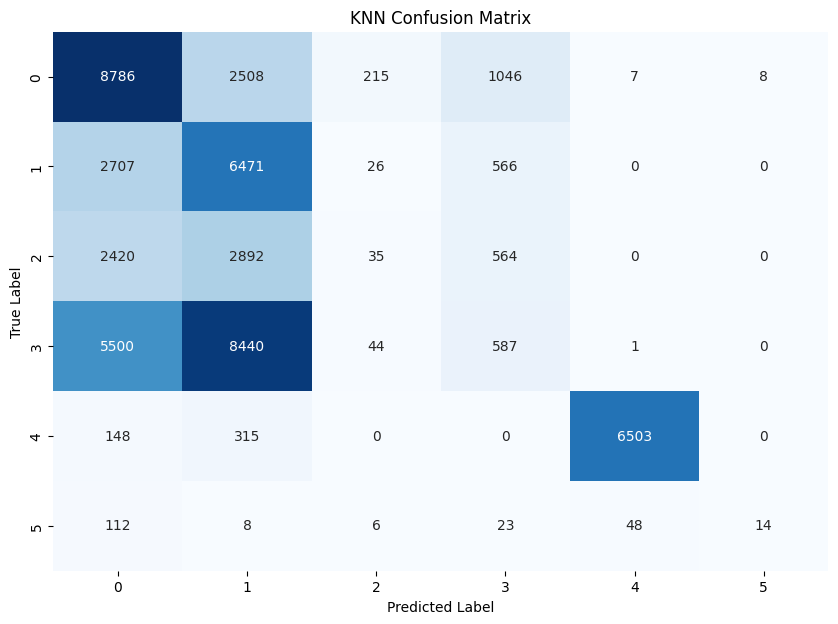

In [16]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(knn_model, "KNN", X_train, X_test, y_train, y_test)

In [ ]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(decision_tree_model, "Decision Tree", X_train, X_test, y_train, y_test)

2024-11-25 14:01:24,686 - INFO - Training CatBoost model...
2024-11-25 14:02:25,330 - INFO - CatBoost predicting on test dataset...
2024-11-25 14:02:26,078 - INFO - Evaluating CatBoost and storing results...


Accuracy: 0.46104
F1-Score: 0.40434775695655684


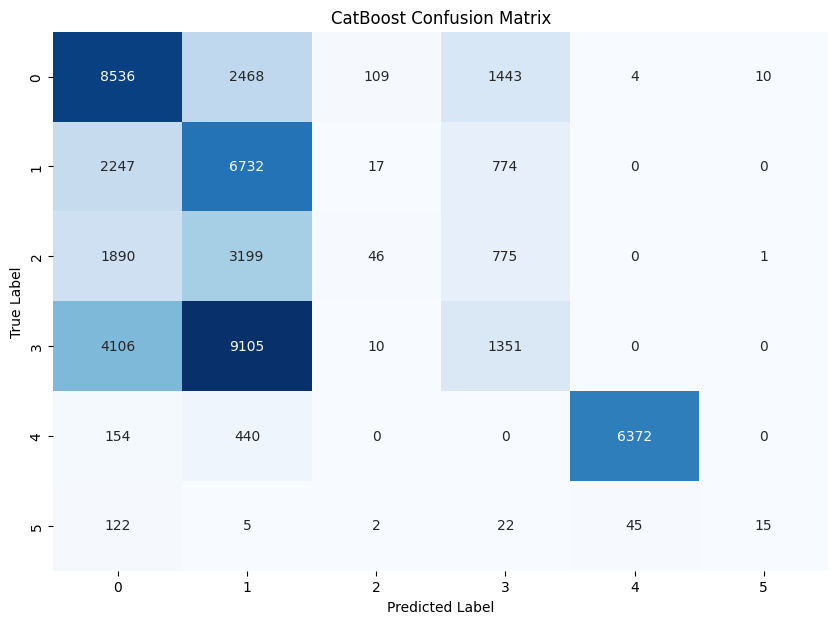

In [17]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(catboost_model, "CatBoost", X_train, X_test, y_train, y_test)

In [ ]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(xgboost_model, "XGBoost", X_train, X_test, y_train, y_test)

In [ ]:
# Train, predict and evaluate SVM model
train_predict_evaluate_model(lgbm_model, "LGBM", X_train, X_test, y_train, y_test)

### Train ensemble model

2024-11-25 14:08:34,786 - INFO - Training ensemble model with CatBoost, XGBoost, and LGBM...


Learning rate set to 0.376357
0:	learn: 1.0518894	total: 64.6ms	remaining: 12.9s
1:	learn: 0.8908473	total: 109ms	remaining: 10.8s
2:	learn: 0.8044024	total: 155ms	remaining: 10.2s
3:	learn: 0.7456386	total: 202ms	remaining: 9.89s
4:	learn: 0.7046934	total: 254ms	remaining: 9.92s
5:	learn: 0.6786369	total: 301ms	remaining: 9.73s
6:	learn: 0.6559241	total: 352ms	remaining: 9.72s
7:	learn: 0.6418851	total: 401ms	remaining: 9.63s
8:	learn: 0.6286071	total: 453ms	remaining: 9.62s
9:	learn: 0.6210976	total: 498ms	remaining: 9.47s
10:	learn: 0.6117166	total: 552ms	remaining: 9.48s
11:	learn: 0.6042310	total: 605ms	remaining: 9.47s
12:	learn: 0.5994525	total: 651ms	remaining: 9.36s
13:	learn: 0.5940790	total: 700ms	remaining: 9.3s
14:	learn: 0.5895326	total: 745ms	remaining: 9.19s
15:	learn: 0.5860503	total: 797ms	remaining: 9.17s
16:	learn: 0.5833132	total: 841ms	remaining: 9.05s
17:	learn: 0.5779568	total: 897ms	remaining: 9.07s
18:	learn: 0.5733001	total: 955ms	remaining: 9.09s
19:	learn: 

c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:08:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 60
[LightGBM] [Info] Start training from score -1.157980
[LightGBM] [Info] Start training from score -1.560172
[LightGBM] [Info] Start training from score -2.405061
[LightGBM] [Info] Start training from score -2.355564
[LightGBM] [Info] Start training from score -3.395613
[LightGBM] [Info] Start training from score -1.358057


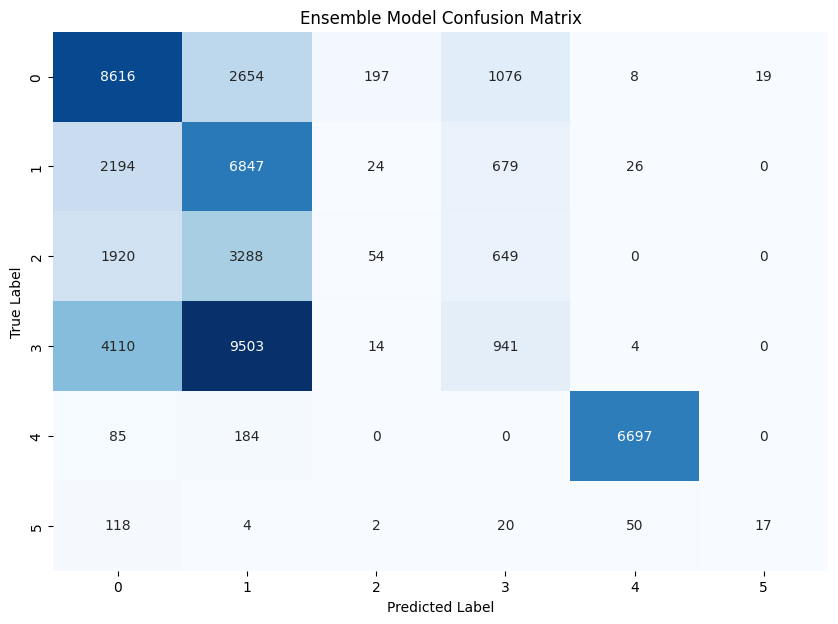

Ensemble Model F1-Score: 0.3981833448175127


In [21]:
# Initialize individual models
catboost_model = CatBoostClassifier(iterations=200, verbose=1, random_state=42)
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgboost_model),
    ('lgbm', lgbm_model)
], voting='soft')  # Use 'soft' voting to take probability into account

# Train the ensemble model
logging.info("Training ensemble model with CatBoost, XGBoost, and LGBM...")
ensemble_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ensemble_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Store results
results = {
    "Accuracy": accuracy,
    "F1-Score": f1,
}

# Save results to a file
result_file = os.path.join(output_dir, "ensemble_results.json")
with open(result_file, 'w') as f:
    json.dump(results, f, indent=4)

# Visualize and save confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Ensemble Model Confusion Matrix')
plt.savefig(os.path.join(output_dir, "ensemble_confusion_matrix.png"))
plt.show()

# Print and save ranking
print(f"Ensemble Model F1-Score: {f1}")

### Train neural network

In [ ]:
# problem with balancing. Have tried: Over-sampling (SMOTE), adjusting class weigths, 

set_random_seed(random_seed)

# Split the dataset into training and testing sets (80% train, 20% test)
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(X_test, y_test, test_size=test_size, random_state=random_seed)

# Convert labels to categorical (one-hot encoded) for Keras
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val_nn)
y_test_cat = to_categorical(y_test_nn)

# Check the shape to ensure correctness
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train_cat.shape}")
print(f"X_val shape: {X_val_nn.shape}, y_val shape: {y_val_cat.shape}")
print(f"X_test shape: {X_test_nn.shape}, y_test shape: {y_test_cat.shape}")


# Define the Keras neural network model
def create_nn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))  # Hidden layer 1
    model.add(Dense(64, activation='relu'))  # Hidden layer 2
    model.add(Dense(num_classes, activation='softmax'))  # Output layer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the neural network model
nn_model = create_nn_model(input_shape=X_train.shape[1], num_classes=y_train_cat.shape[1])

# Train, predict, and evaluate the neural network model
model_name = "Neural Network"

#if not os.path.exists(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")):
logging.info(f"Training {model_name} model...")
nn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val_nn, y_val_cat), verbose=2)

# Predict on the test set
y_pred_prob = nn_model.predict(X_test_nn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred)
conf_matrix = confusion_matrix(y_test_labels, y_pred)
class_report = classification_report(y_test_labels, y_pred, output_dict=True)
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# Store results
results[model_name] = {
    "Accuracy": accuracy,
    "F1-Score": f1
}

# Save results to a file
result_file = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")
with open(result_file, 'w') as f:
    json.dump(results[model_name], f, indent=4)

# Visualize and save confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"))

# Print the F1-score
print(f"{model_name} F1-Score: {f1}")
print(class_report)


### Train convolutional neural network

In [ ]:
set_random_seed(random_seed)

# Split the dataset into training and testing sets (80% train, 20% test)
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(X_test, y_test, test_size=test_size, random_state=random_seed)

# Convert labels to categorical (one-hot encoded) for Keras
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val_nn)
y_test_cat = to_categorical(y_test_nn)

# Check the shape to ensure correctness
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train_cat.shape}")
print(f"X_val shape: {X_val_nn.shape}, y_val shape: {y_val_cat.shape}")
print(f"X_test shape: {X_test_nn.shape}, y_test shape: {y_test_cat.shape}")


# Define the Keras neural network model
def create_nn_model(input_shape, num_classes):
    ## input layer
    input_layer = Input((input_shape, 1))

    ## convolutional layers
    conv_layer1 = Conv1D(filters=8, kernel_size=7, activation='relu')(input_layer)
    conv_layer2 = Conv1D(filters=16, kernel_size=5, activation='relu')(conv_layer1)
    conv_layer3 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv_layer2)

    flatten_layer = Flatten()(conv_layer3)

    ## fully connected layers
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=num_classes, activation='softmax')(dense_layer2)
    # define the model with input layer and output layer
    model = Model(inputs=input_layer, outputs=output_layer)


    # Define the initial learning rate and decay steps
    initial_learning_rate = 0.001
    decay_steps = 100000
    decay_rate = 0.96

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    # Create an Adam optimizer with the learning rate schedule
    adam = Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# Create the neural network model
nn_model = create_nn_model(input_shape=X_train.shape[1], num_classes=y_train_cat.shape[1])

# Train, predict, and evaluate the neural network model
model_name = "Convolutional Neural Network"

# checkpoint
filepath = "1DCNN_best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#if not os.path.exists(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")):
logging.info(f"Training {model_name} model...")
nn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val_nn, y_val_cat), verbose=2)

# Predict on the test set
y_pred_prob = nn_model.predict(X_test_nn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred)
conf_matrix = confusion_matrix(y_test_labels, y_pred)
class_report = classification_report(y_test_labels, y_pred, output_dict=True)
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# Store results
results[model_name] = {
    "Accuracy": accuracy,
    "F1-Score": f1
}

# Save results to a file
result_file = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")
with open(result_file, 'w') as f:
    json.dump(results[model_name], f, indent=4)

# Visualize and save confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"))

# Print the F1-score
print(f"{model_name} F1-Score: {f1}")
print(class_report)

nn_model.save("1DCNN_best-model.hdf5")
nn_model.save('1DCNN_best-model.keras')



### Train convolutional neural network without background

X_train shape: (8199, 200), y_train shape: (8199, 16)
X_val shape: (410, 200), y_val shape: (410, 16)
X_test shape: (1640, 200), y_test shape: (1640, 16)


2024-10-28 13:58:38,659 - INFO - Training Convolutional Neural Network without background model...


Epoch 1/10
257/257 - 9s - 36ms/step - accuracy: 0.2203 - loss: 30.0700 - val_accuracy: 0.1976 - val_loss: 2.5678
Epoch 2/10
257/257 - 3s - 12ms/step - accuracy: 0.2417 - loss: 2.4586 - val_accuracy: 0.1976 - val_loss: 2.4581
Epoch 3/10
257/257 - 3s - 11ms/step - accuracy: 0.2415 - loss: 2.3822 - val_accuracy: 0.1976 - val_loss: 2.4280
Epoch 4/10
257/257 - 3s - 11ms/step - accuracy: 0.2403 - loss: 2.3615 - val_accuracy: 0.1976 - val_loss: 2.4170
Epoch 5/10
257/257 - 3s - 11ms/step - accuracy: 0.2410 - loss: 2.3562 - val_accuracy: 0.1976 - val_loss: 2.4125
Epoch 6/10
257/257 - 3s - 11ms/step - accuracy: 0.2404 - loss: 2.3464 - val_accuracy: 0.1976 - val_loss: 2.4112
Epoch 7/10
257/257 - 3s - 11ms/step - accuracy: 0.2431 - loss: 2.3443 - val_accuracy: 0.1976 - val_loss: 2.4104
Epoch 8/10
257/257 - 3s - 11ms/step - accuracy: 0.2420 - loss: 2.3413 - val_accuracy: 0.1976 - val_loss: 2.4096
Epoch 9/10
257/257 - 3s - 11ms/step - accuracy: 0.2415 - loss: 2.3377 - val_accuracy: 0.1976 - val_loss

c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Convolutional Neural Network without background F1-Score: 0.09052773367970367
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 216.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 136.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 31.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 72.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 124.0}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 89.0}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 171.0}, '10': {'precision': 0.23658536585365852, 'recall': 1.0, 'f1-score': 0.3826429980276134, 'support': 388.0}, '11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 92.0}, '12': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 27

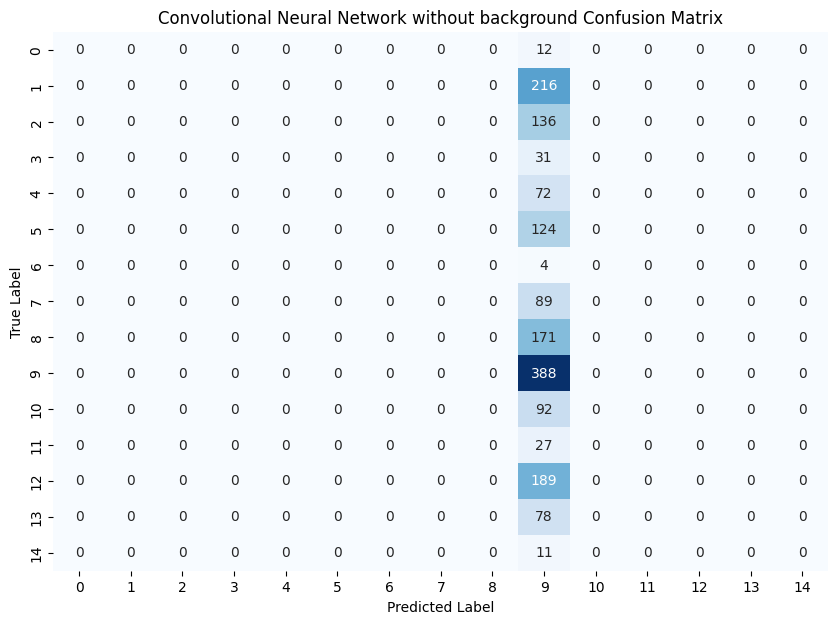

In [22]:
set_random_seed(random_seed)

# Split the dataset into training and testing sets (80% train, 20% test)
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(X_removed_test, y_removed_test, test_size=test_size, random_state=random_seed)

# Convert labels to categorical (one-hot encoded) for Keras
y_train_cat = to_categorical(y_removed_train)
y_val_cat = to_categorical(y_val_nn)
y_test_cat = to_categorical(y_test_nn)

# Check the shape to ensure correctness
print(f"X_train shape: {X_removed_train.shape}, y_train shape: {y_train_cat.shape}")
print(f"X_val shape: {X_val_nn.shape}, y_val shape: {y_val_cat.shape}")
print(f"X_test shape: {X_test_nn.shape}, y_test shape: {y_test_cat.shape}")


# Define the Keras neural network model
def create_nn_model(input_shape, num_classes):
    ## input layer
    input_layer = Input((input_shape, 1))

    ## convolutional layers
    conv_layer1 = Conv1D(filters=8, kernel_size=7, activation='relu')(input_layer)
    conv_layer2 = Conv1D(filters=16, kernel_size=5, activation='relu')(conv_layer1)
    conv_layer3 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv_layer2)

    flatten_layer = Flatten()(conv_layer3)

    ## fully connected layers
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=num_classes, activation='softmax')(dense_layer2)
    # define the model with input layer and output layer
    model = Model(inputs=input_layer, outputs=output_layer)


    # Define the initial learning rate and decay steps
    initial_learning_rate = 0.001
    decay_steps = 100000
    decay_rate = 0.96

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    # Create an Adam optimizer with the learning rate schedule
    adam = Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# Create the neural network model
nn_model = create_nn_model(input_shape=X_removed_train.shape[1], num_classes=y_train_cat.shape[1])

# Train, predict, and evaluate the neural network model
model_name = "Convolutional Neural Network without background"

# checkpoint
filepath = "1DCNN_without_background_best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#if not os.path.exists(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")):
logging.info(f"Training {model_name} model...")
nn_model.fit(X_removed_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val_nn, y_val_cat), verbose=2)

# Predict on the test set
y_pred_prob = nn_model.predict(X_test_nn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred)
conf_matrix = confusion_matrix(y_test_labels, y_pred)
class_report = classification_report(y_test_labels, y_pred, output_dict=True)
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# Store results
results[model_name] = {
    "Accuracy": accuracy,
    "F1-Score": f1
}

# Save results to a file
result_file = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")
with open(result_file, 'w') as f:
    json.dump(results[model_name], f, indent=4)

# Visualize and save confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"))

# Print the F1-score
print(f"{model_name} F1-Score: {f1}")
print(class_report)

nn_model.save("1DCNN_without_background_model.hdf5")
nn_model.save('1DCNN_without_background_model.keras')



### Train model with data with reduced dimensions

2024-10-28 11:28:44,016 - INFO - Training Random Forest_PCA model...
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

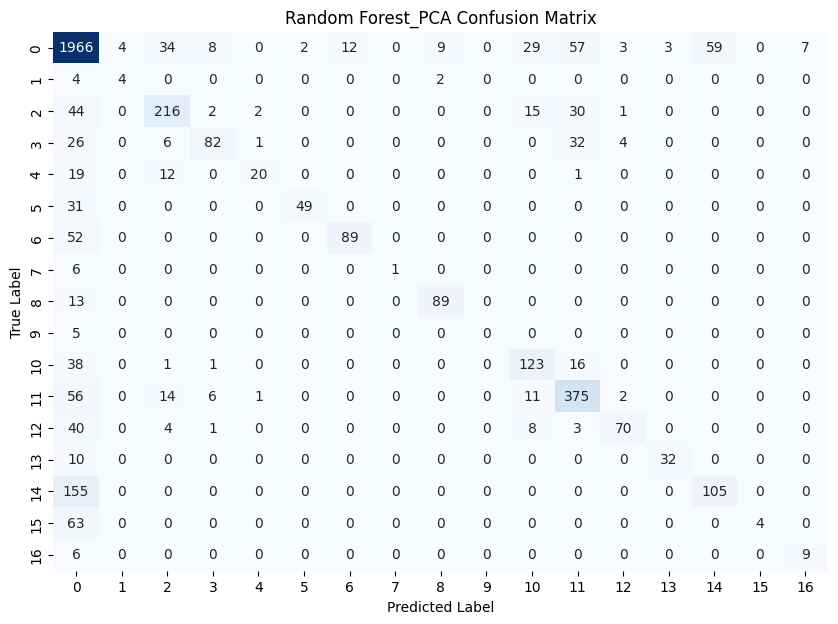

2024-10-28 11:28:56,205 - INFO - Training Random Forest_UMAP model...
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

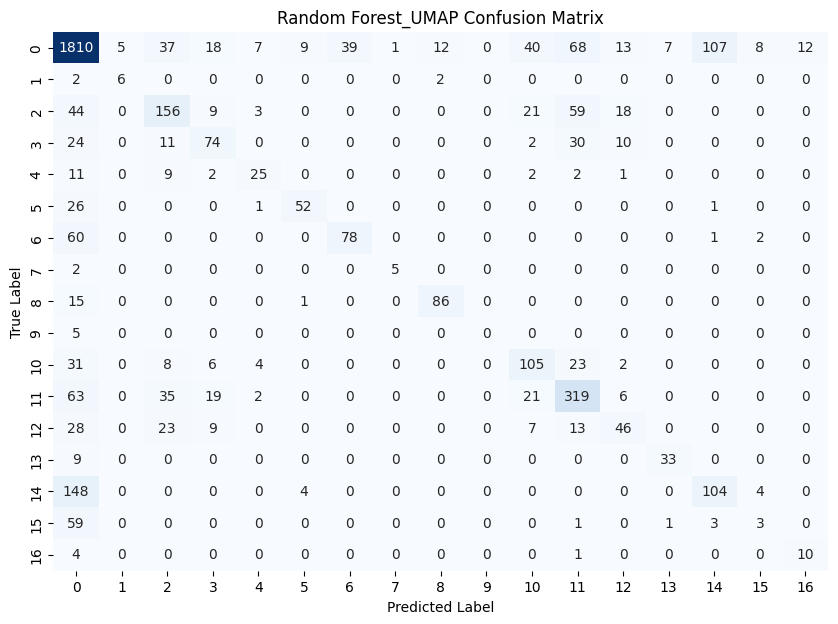

2024-10-28 11:29:07,627 - INFO - Training Random Forest_t-SNE model...


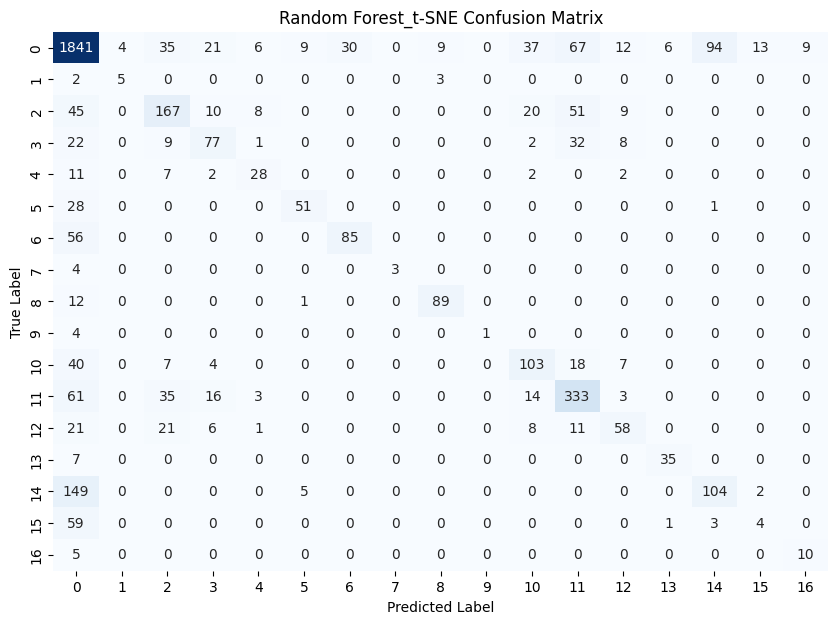

In [13]:
# Train and evaluate the model on PCA, UMAP, and t-SNE processed datasets
for reduction_technique, (X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced) in {
    'PCA': (X_pca_train, X_pca_test, y_pca_train, y_pca_test),
    'UMAP': (X_umap_train, X_umap_test, y_umap_train, y_umap_test),
    't-SNE': (X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test)
}.items():
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=random_seed)
    model_name = f"Random Forest_{reduction_technique}"

    logging.info(f"Training {model_name} model...")
    model.fit(X_train_reduced, y_train_reduced)

    # Predict on test set
    y_pred = model.predict(X_test_reduced)

    # Calculate metrics
    accuracy = accuracy_score(y_test_reduced, y_pred)
    conf_matrix = confusion_matrix(y_test_reduced, y_pred)
    class_report = classification_report(y_test_reduced, y_pred, output_dict=True)
    f1 = f1_score(y_test_reduced, y_pred, average='weighted')

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "F1-Score": f1
    }

    # Save results to a file
    result_file = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")
    with open(result_file, 'w') as f:
        json.dump(results[model_name], f, indent=4)

    # Visualize and save confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"))
    plt.show()

### Train model with data without background

2024-10-28 14:24:11,879 - INFO - Training LGBM without background model...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47303
[LightGBM] [Info] Number of data points in the train set: 8199, number of used features: 200
[LightGBM] [Info] Start training from score -5.610570
[LightGBM] [Info] Start training from score -1.956455
[LightGBM] [Info] Start training from score -2.530190
[LightGBM] [Info] Start training from score -3.723500
[LightGBM] [Info] Start training from score -3.055930
[LightGBM] [Info] Start training from score -2.659138
[LightGBM] [Info] Start training from score -5.833714
[LightGBM] [Info] Start training from score -3.090189
[LightGBM] [Info] Start training from score -6.121396
[LightGBM] [Info] Start training from score -2.373200
[LightGBM] [Info] Start training from score -1.417890
[LightGBM] [Info] Start training from score -2.856909
[LightGBM] [Info] Start training from score -3.870104
[LightGB

c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elise\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

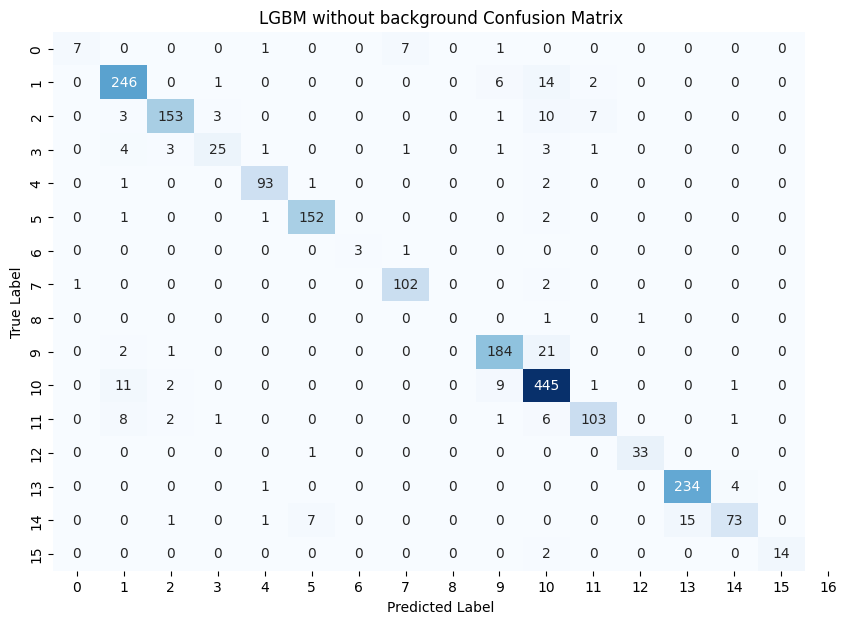

In [29]:
model = LGBMClassifier(random_state=random_seed)
model_name = f"LGBM without background"

logging.info(f"Training {model_name} model...")
model.fit(X_removed_train, y_removed_train)

# Predict on test set
y_pred = model.predict(X_removed_test)

# Calculate metrics
accuracy = accuracy_score(y_removed_test, y_pred)
conf_matrix = confusion_matrix(y_removed_test, y_pred)
class_report = classification_report(y_removed_test, y_pred, output_dict=True)
f1 = f1_score(y_removed_test, y_pred, average='weighted')

# Store results
results[model_name] = {
    "Accuracy": accuracy,
    "F1-Score": f1
}

# Save results to a file
result_file = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_results.json")
with open(result_file, 'w') as f:
    json.dump(results[model_name], f, indent=4)

# Visualize and save confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y), yticklabels=np.unique(y_removed))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"))
plt.show()

## Compare models

Models ranked by F1-Score:
1. lgbm without background - F1-Score: 0.9085345789424187
2. random forest without background - F1-Score: 0.8604957815540122
3. lgbm - F1-Score: 0.8255656514320642
4. xgboost - F1-Score: 0.82516651980522
5. ensemble - F1-Score: 0.825047681712604
6. catboost - F1-Score: 0.8136928376251248
7. random forest - F1-Score: 0.7879824430575434
8. lgbm pca - F1-Score: 0.7697765858572071
9. random forest pca - F1-Score: 0.7554351754814905
10. knn - F1-Score: 0.7198607992578098
11. random forest t-sne - F1-Score: 0.7031042757231263
12. decision tree - F1-Score: 0.6916063273354661
13. random forest umap - F1-Score: 0.6836676661140102
14. logistic regression - F1-Score: 0.584492841410194
15. lgbm umap - F1-Score: 0.4366195602717665
16. convolutional neural network - F1-Score: 0.3611026943618032
17. lgbm t-sne - F1-Score: 0.35915827201404565
18. svm - F1-Score: 0.328177752416025
19. convolutional neural network without background - F1-Score: 0.09052773367970367
20. neural n

C:\Users\elise\AppData\Local\Temp\ipykernel_37064\3797662635.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=model_names, palette='viridis')


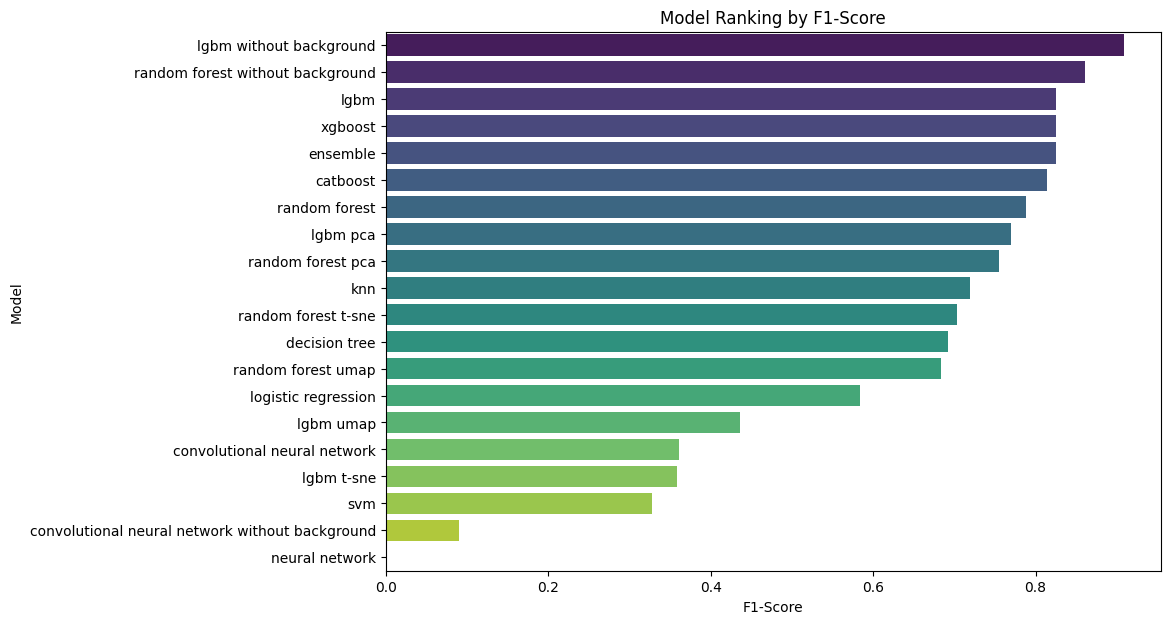

In [5]:
# Initialize an empty dictionary to store the results
model_results = {}

# Directory where the JSON files are located
directory = 'model_results'

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('_results.json'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Open and read the JSON file
        with open(file_path, 'r') as file:
            data = json.load(file)
            
            # Extract model_name and f1-score
            model_name = filename.replace('_results.json', '').replace('_', ' ')
            f1_score = data.get('F1-Score')
            
            # Store them in the dictionary
            if model_name and f1_score is not None:
                model_results[model_name] = f1_score

# Rank models by F1-Score
sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

# Print the ranking
print("Models ranked by F1-Score:")
for rank, (model_name, f1_score) in enumerate(sorted_models, 1):
    print(f"{rank}. {model_name} - F1-Score: {f1_score}")

# Save ranking to a file
ranking_file = os.path.join(output_dir, "model_f1_ranking.json")
with open(ranking_file, 'w') as f:
    json.dump(sorted_models, f, indent=4)

# Visualize the ranking
plt.figure(figsize=(10, 7))
model_names = [model_name for model_name, _ in sorted_models]
f1_scores = [f1_score for _, f1_score in sorted_models]
sns.barplot(x=f1_scores, y=model_names, palette='viridis')
plt.xlabel('F1-Score')
plt.ylabel('Model')
plt.title('Model Ranking by F1-Score')
plt.show()


C:\Users\elise\AppData\Local\Temp\ipykernel_37064\3962919825.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=model_names, palette='viridis')


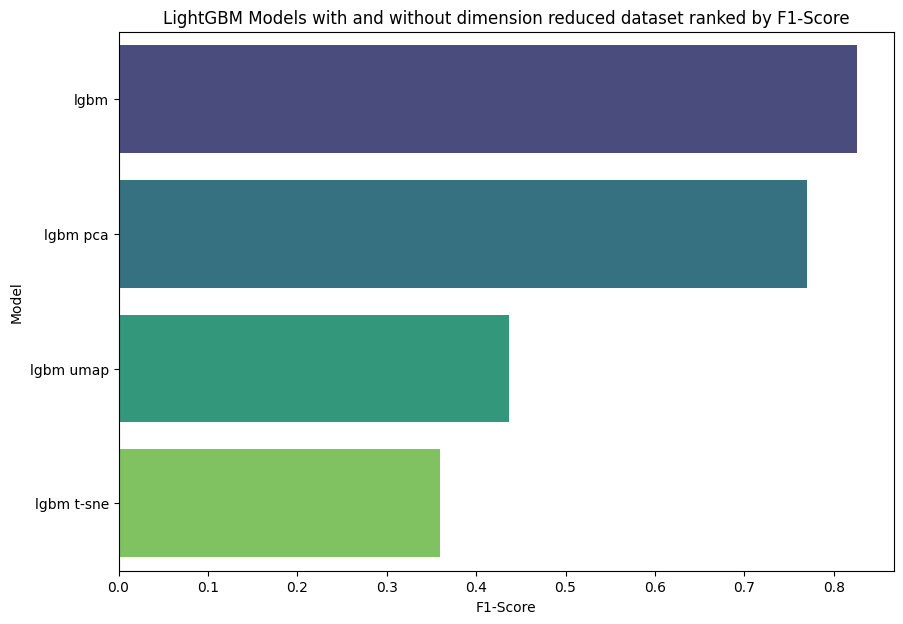

C:\Users\elise\AppData\Local\Temp\ipykernel_37064\3962919825.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=model_names, palette='viridis')


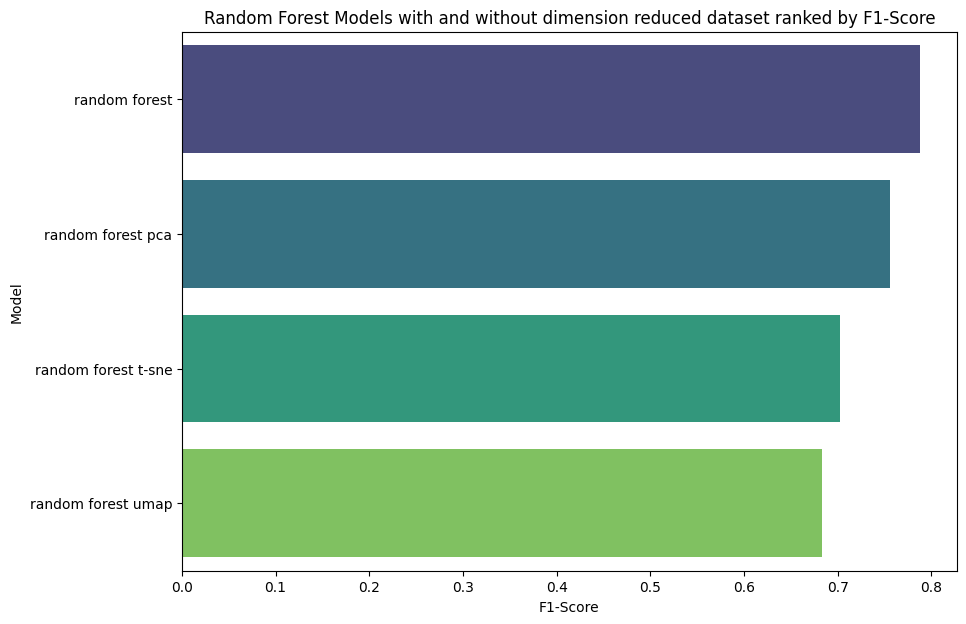

In [8]:
# Filter for "lgbm" related models
lgbm_models = {name: score for name, score in model_results.items() if 'lgbm' in name.lower() and "background" not in name.lower()}

# Filter for "random forest" related models
random_forest_models = {name: score for name, score in model_results.items() if 'random forest' in name.lower() and "background" not in name.lower()}

# Plot function
def plot_models(models, title):
    sorted_models = sorted(models.items(), key=lambda x: x[1], reverse=True)
    model_names = [model_name for model_name, _ in sorted_models]
    f1_scores = [f1_score for _, f1_score in sorted_models]
    
    plt.figure(figsize=(10, 7))
    sns.barplot(x=f1_scores, y=model_names, palette='viridis')
    plt.xlabel('F1-Score')
    plt.ylabel('Model')
    plt.title(title)
    plt.savefig(os.path.join(output_dir, f"{title.replace(' ', '_').lower()}.png"))
    plt.show()

# Plot for lgbm models
plot_models(lgbm_models, 'LightGBM Models with and without dimension reduced dataset ranked by F1-Score')

# Plot for random forest models
plot_models(random_forest_models, 'Random Forest Models with and without dimension reduced dataset ranked by F1-Score')

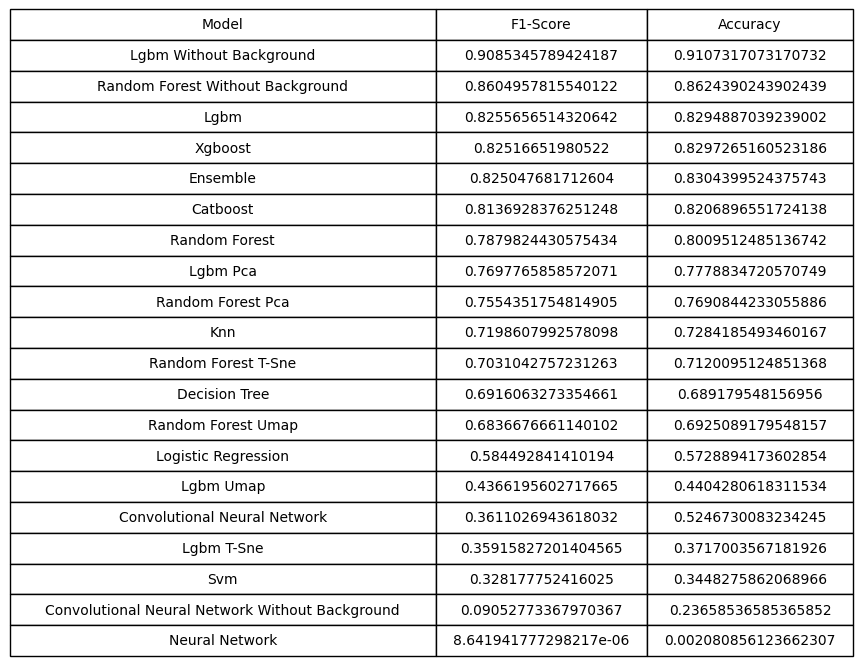

Table saved as model_results_table.png. You can now include it in your LaTeX document.


In [15]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to store model results
model_results = []

# Directory where the JSON files are located
directory = 'model_results'

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('_results.json'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Open and read the JSON file
        with open(file_path, 'r') as file:
            data = json.load(file)
            
            # Extract model_name, F1-Score, and Accuracy
            model_name = filename.replace('_results.json', '').replace('_', ' ').title()
            f1_score = data.get('F1-Score')
            accuracy = data.get('Accuracy')
            
            # Append the results to the list
            model_results.append({
                "Model": model_name,
                "F1-Score": f1_score,
                "Accuracy": accuracy
            })

# Convert the results into a DataFrame
df = pd.DataFrame(model_results)

# Sort by F1-Score in descending order
df = df.sort_values(by="F1-Score", ascending=False)

# Save the table as an image
plt.figure(figsize=(8, len(df) * 0.2))  # Adjust figure size based on number of rows
plt.axis('off')  # Turn off the axis

# Add the table
table = plt.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(10)
for key, cell in table.get_celld().items():
    cell.set_height(0.1)  # Increase vertical space for each row

# Adjust column width
table.auto_set_column_width([0, 1, 2])

# Save as an image
output_image_path = "model_results_table.png"
plt.savefig(output_image_path, dpi=300, bbox_inches='tight')

# Display the table
plt.show()

print(f"Table saved as {output_image_path}. You can now include it in your LaTeX document.")
